## Replicating a machine learning research paper to create a Vision Transformer (ViT) from scratch using PyTorch

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


In [ ]:
"""
Create the going_modular folder and move in its scripts.
"""
import os

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
  print("going_modular scripts already downloaded.")
except:
  # Get the going_modular scripts
  print("Downloading going_modular scripts...")
  !git clone https://github.com/lanehale/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  print("going_modular downloaded.")
  from going_modular import data_setup, engine

print(">!ls going_modular")
!ls going_modular

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 505 (delta 167), reused 48 (delta 48), pack-reused 259 (from 2)
Receiving objects: 100% (505/505), 8.61 MiB | 36.74 MiB/s, done.
Resolving deltas: 100% (284/284), done.
going_modular downloaded.
>!ls going_modular
data_setup.py	  get_custom_data.py  pretrained_confmat.py  utils.py
download_data.py  get_data.py	      pretrained_writer.py
engine.py	  model_builder.py    __pycache__
get_any_data.py   predict.py	      train.py


'cuda'

In [ ]:
import torch
import torchvision

from pathlib import Path
from going_modular import download_data

# Download 10 percent and 20 percent training data
data_10_percent_path = download_data.from_path(from_path="pizza_steak_sushi.zip", image_dir="pizza_steak_sushi")
data_20_percent_path = download_data.from_path(from_path="pizza_steak_sushi_20_percent.zip", image_dir="pizza_steak_sushi_20_percent")

# Set up training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths
test_dir_10 = data_10_percent_path / "test"
test_dir_20 = data_20_percent_path / "test"

test_image_path_list_10 = list(Path(test_dir_10).glob("*/*.jpg"))  # this is only used for predictions
test_image_path_list_20 = list(Path(test_dir_20).glob("*/*.jpg"))  # this is only used for predictions

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza_steak_sushi data...
>!ls data/pizza_steak_sushi
test
train

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza_steak_sushi_20_percent data...
>!ls data/pizza_steak_sushi_20_percent
test
train



In [ ]:
def set_seeds(seed: int=42):
  """Sets random sets for torch operations.

  Args:
    seed (int, optional): Random seed to set. Defaults to 42.
  """
  # Set the seed for general torch operations
  torch.manual_seed(42)
  torch.cuda.manual_seed(42)

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b6a1a9a9a10>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

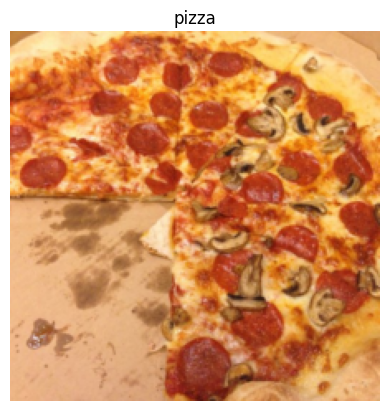

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

### Equation 1: Split data into patches, and create the class, position and patch embedding

In [ ]:
"""
- D is the size of the patch embeddings, different values for D for various sized ViT models can be found in Table 1 of the ViT paper.
- The image starts as 2D with size H times W times C.
  - (H, W) is the resolution of the original image (height, width).
  - C is the number of channels.
- The image gets converted to a sequence of flattened 2D patches with size N times (P^2 cdot C).
- (P, P) is the resolution of each image patch (patch size).
- N = H W / P^2 is the resulting number of patches, which also serves as the input sequence length for the Transformer.
"""
# Create example values
height = 224        # H
width = 224         # W
color_channels = 3  # C
patch_size = 16     # P

# Calculate N (number of patches)
number_of_patches = (height * width) / patch_size**2
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196.0


In [ ]:
"""
Input: The image starts as 2D with size H times W times C.
Output: The image gets converted to a 1D sequence of flattened 2D patches with size N times (P^2 cdot C).
"""
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)  # power of operator **

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196.0, 768)


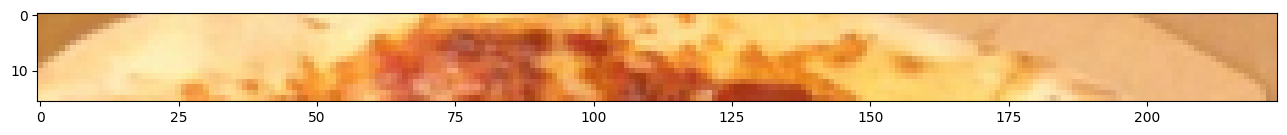

In [ ]:
"""
Turn an image into a sequence of flattened 2D patches.
Start by visualizing just the top row of patched pixels.
Do this by indexing on the different image dimensions.
"""
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


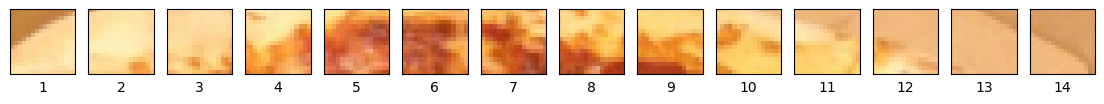

In [ ]:
"""
Now we've got the top row, let's turn it into patches.
Do this by iterating through the number of patches in the top row.
"""
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);  # keep height index constant, alter the width index
  axs[i].set_xlabel(i+1)  # set the label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: (patch_size) pixels x 16 pixels


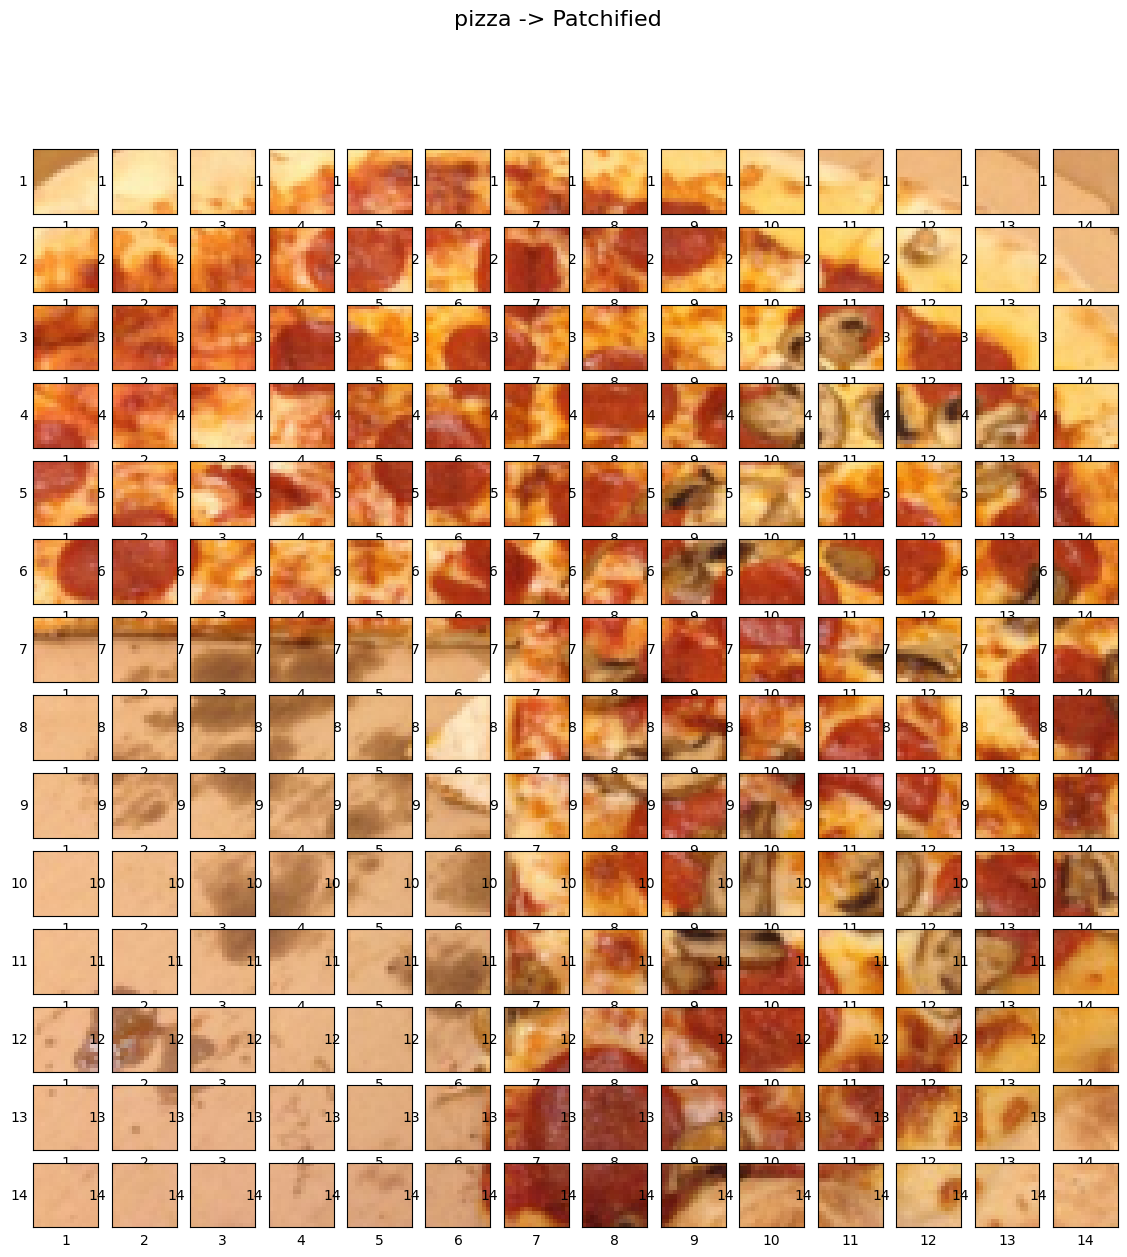

In [ ]:
# Alredy set up hyperparameters and verified img_size and patch_size are compatible
""" backward slash continues line, don't have to indent next line(s) """
print(f"Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches * num_patches}\
      \nPatch size: (patch_size) pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,  # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):  # iterate through height
  for j, patch_width in enumerate(range(0, img_size, patch_size)):  # iterate through width

    # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,  # iterate through height
                                    patch_width:patch_width+patch_size,    # iterate through width
                                    :])                                    # get all color channels

    # Set up label information, remove the ticks for clarity and set labels to outside
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i, j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

Creating image patches with torch.nn.Conv2d

In [ ]:
"""
For an image size of 224 and patch size of 16:

Input (2D image): (224, 224, 3) -> (height, width, color channels)
Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:

- torch.nn.Conv2d() for turning our image into patches of CNN feature maps.
- torch.nn.Flatten() for flattening the spatial dimensions of the feature map.

------------------------------------------------------------------------------
Starting with the torch.nn.Conv2d() layer.

We can replicate the creation of patches by setting the kernel_size and stride equal to patch_size.

This means each convolutional kernel will be of size (patch_size x patch_size) or if patch_size=16,
(16 x 16) (the equivalent of one whole patch).

And each step or stride of the convolutional kernel will be patch_size pixels long or 16 pixels long
(equivalent of stepping to the next patch).

We'll set in_channels=3 for the number of color channels in our image and we'll set out_channels=768,
the same as the D value in Table 1 for ViT-Base (this is the embedding dimension, each image will be
embedded into a learnable vector of size 768).

"""
from torch import nn

# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,           # number of color channels
                   out_channels=768,        # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size,  # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

# Pass the image through the convolutional layer
"""
Passing our image through the convolutional layer turns it into a series of 768 (this is
the embedding size or D) feature/activation maps. So its output shape can be read as:

torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
"""
image_from_conv = conv2d(image.unsqueeze(0))  # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)

print(f"Output shape after convolutional layer: {image_from_conv.shape}")

Output shape after convolutional layer: torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [159, 560, 506, 418, 672]


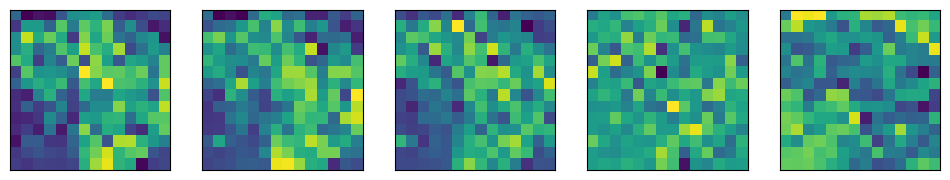

In [ ]:
"""
Visualize five random feature maps from the convolutional layer.
"""
# Plot random 5 convolutional feature maps
import random
random_indices = random.sample(range(0, 768), k=5)  # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indices}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indices):
  image_conv_feature_map = image_from_conv[:, idx, :, :]  # index on the output tensor of the convolutional layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [ ]:
# Get a single feature map in tensor form
"""
The grad_fn output of the single_feature_map and the requires_grad=True attribute means PyTorch is
tracking the gradients of this feature map and it will be updated by gradient descent during training.
"""
single_feature_map = image_from_conv[:, 287, :, :]
single_feature_map.shape, single_feature_map.requires_grad, single_feature_map

(torch.Size([1, 14, 14]),
 True,
 tensor([[[0.4979, 0.5675, 0.5467, 0.5031, 0.4717, 0.4461, 0.3282, 0.3720,
           0.4911, 0.4288, 0.5939, 0.5510, 0.5635, 0.4856],
          [0.4003, 0.4377, 0.4329, 0.3582, 0.4431, 0.3180, 0.3305, 0.4417,
           0.3905, 0.5281, 0.4287, 0.4455, 0.5610, 0.5568],
          [0.3828, 0.3119, 0.3059, 0.3513, 0.4209, 0.4050, 0.2964, 0.3853,
           0.4788, 0.4159, 0.5644, 0.3989, 0.4551, 0.5760],
          [0.4551, 0.4216, 0.4721, 0.5091, 0.2425, 0.2914, 0.2028, 0.3305,
           0.3540, 0.2461, 0.4122, 0.4000, 0.2269, 0.4785],
          [0.3358, 0.4204, 0.5091, 0.3235, 0.3661, 0.4435, 0.3201, 0.2636,
           0.5910, 0.5231, 0.4004, 0.2416, 0.4048, 0.3488],
          [0.4182, 0.3696, 0.3360, 0.4889, 0.4410, 0.4635, 0.2363, 0.2370,
           0.2644, 0.3001, 0.3405, 0.3017, 0.3280, 0.3286],
          [0.5302, 0.4785, 0.3610, 0.3291, 0.4448, 0.4780, 0.3488, 0.3277,
           0.2905, 0.2442, 0.2990, 0.4608, 0.3604, 0.2925],
          [0.5624, 0.5

Flattening the patch embedding with torch.nn.Flatten

In [ ]:
"""
We've turned our image into patch embeddings but they're still in 2D format.
How do we get them into the desired output shape of the patch embedding layer of the ViT model?
Desired output (1D sequence of flattened 2D patches): (196, 768) -> (number of patches, embedding dimension) -> N times (P^2 cdot C)
"""
# Current tensor shape
print(f"Current tensor shape: {image_from_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [ ]:
"""
We don't want to flatten the whole tensor, we only want to flatten the "spatial dimensions of the feature map."
Which in our case is the feature_map_height and feature_map_width dimensions of image_from_conv.
"""
# Create flatten layer
flatten = nn.Flatten(start_dim=2,  # flatten feature_map_height (dimension 2)
                     end_dim=3)    # flatten feature_map_width (dimension 3)

# 1. View single image (already done above)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps (already done above)
print(f"Image feature map shape: {image_from_conv.shape}")

# 3. Flatten the feature maps
image_from_conv_flattened = flatten(image_from_conv)
print(f"Flattened image feature map shape: {image_from_conv_flattened.shape}")

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


In [ ]:
"""
The image_from_conv_flattened shape is close to our desired output shape (flattened 2D patches): (196, 768).
The only difference is the order of the batch size and dimensions. We'll rearrange the dimensions.
"""
# Get flattened image patch embeddings in right shape
image_from_conv_flat_reshaped = image_from_conv_flattened.permute(0, 2, 1)  # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_from_conv_flat_reshaped.shape} -> [batch_size, num_of_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_of_patches, embedding_size]


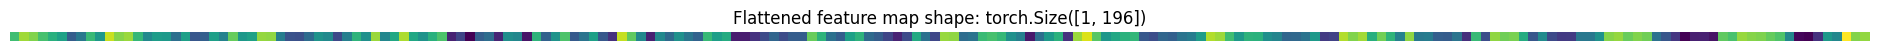

In [ ]:
"""
We've turned our single 2D image into a 1D learnable embedding vector (or "Linear Projection of Flattened Patches" in Figure 1 of the ViT paper).
"""
# Get a single flattened feature map
single_flattened_feature_map = image_from_conv_flat_reshaped[:, :, 287]  # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(24,24))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [ ]:
# See the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[0.4979, 0.5675, 0.5467, 0.5031, 0.4717, 0.4461, 0.3282, 0.3720, 0.4911,
          0.4288, 0.5939, 0.5510, 0.5635, 0.4856, 0.4003, 0.4377, 0.4329, 0.3582,
          0.4431, 0.3180, 0.3305, 0.4417, 0.3905, 0.5281, 0.4287, 0.4455, 0.5610,
          0.5568, 0.3828, 0.3119, 0.3059, 0.3513, 0.4209, 0.4050, 0.2964, 0.3853,
          0.4788, 0.4159, 0.5644, 0.3989, 0.4551, 0.5760, 0.4551, 0.4216, 0.4721,
          0.5091, 0.2425, 0.2914, 0.2028, 0.3305, 0.3540, 0.2461, 0.4122, 0.4000,
          0.2269, 0.4785, 0.3358, 0.4204, 0.5091, 0.3235, 0.3661, 0.4435, 0.3201,
          0.2636, 0.5910, 0.5231, 0.4004, 0.2416, 0.4048, 0.3488, 0.4182, 0.3696,
          0.3360, 0.4889, 0.4410, 0.4635, 0.2363, 0.2370, 0.2644, 0.3001, 0.3405,
          0.3017, 0.3280, 0.3286, 0.5302, 0.4785, 0.3610, 0.3291, 0.4448, 0.4780,
          0.3488, 0.3277, 0.2905, 0.2442, 0.2990, 0.4608, 0.3604, 0.2925, 0.5624,
          0.5567, 0.3550, 0.3662, 0.4917, 0.5035, 0.4877, 0.4182, 0.3874, 0.2311,
          0.3577

In [ ]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """
  # 2. Initialize the class with appropriate variables
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()  # instantiate the parent class

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                              end_dim=3)

  # 5. Define the forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [ ]:
# Set seeds
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))  # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [ ]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250)  # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image,  # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [ ]:
"""
Create the class token embedding (as a learnable parameter) for the patch embedding above.

Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches,
whose state at the output of the Transformer encoder serves as the image representation.

To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding
in the shape of the embedding_dimension (D) and then add it to the number_of_patches dimension.
"""
# View the patch embedding and patch embedding shape
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.8398,  0.2544, -0.2809,  ...,  0.5580, -0.2479,  0.3147],
         [-0.9390,  0.1044, -0.1544,  ...,  0.6247, -0.4622,  0.3417],
         [-0.8955,  0.1679, -0.1310,  ...,  0.5955, -0.4747,  0.3542],
         ...,
         [-0.8292,  0.1961, -0.1708,  ...,  0.5020, -0.3697,  0.2910],
         [-0.8361,  0.1722, -0.1680,  ...,  0.5191, -0.3885,  0.2980],
         [-0.7785,  0.0953, -0.1476,  ...,  0.5099, -0.3862,  0.3261]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
"""
To create a learnable embedding for the class token, we'll get the batch size and embedding dimension shape
and then we'll create a torch.ones()* tensor in the shape [batch_size, 1, embedding_dimension].

And we'll make the tensor learnable by passing it to nn.Parameter() with requires_grad=True.

*Note: Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality,
you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing
the power of controlled randomness, you generally start with a random number and improve it over time).
"""
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),  # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True)                              # make sure the embedding is learnable

# Show the first 10 example of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
"""
Notice the number_of_tokens dimension of class_token is 1 since we only want to
prepend one class token value to the start of the patch embedding sequence.
"""
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [ ]:
"""
Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image.

We can do so using torch.cat() and set dim=1 (so class_token's number_of_tokens dimension is prepended to
patch_embedded_image's number_of_patches dimension).
"""
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)  # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding (or learnable class token prepended)
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: "
      f"{patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.8398,  0.2544, -0.2809,  ...,  0.5580, -0.2479,  0.3147],
         [-0.9390,  0.1044, -0.1544,  ...,  0.6247, -0.4622,  0.3417],
         ...,
         [-0.8292,  0.1961, -0.1708,  ...,  0.5020, -0.3697,  0.2910],
         [-0.8361,  0.1722, -0.1680,  ...,  0.5191, -0.3885,  0.2980],
         [-0.7785,  0.0953, -0.1476,  ...,  0.5099, -0.3862,  0.3261]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Reviewing what we've done to create the learnable class token, we start with a sequence of image patch embeddings created by PatchEmbedding() on single image, we then created a learnable class token with one value for each of the embedding dimensions and then prepended it to the original sequence of patch embeddings. Note: Using torch.ones() to create the learnable class token is mostly for demonstration purposes only, in practice, you'd likely create it with torch.randn().

In [ ]:
"""
Create the position embedding (to know what "order" the patches come in).
Using torch.ones() again for demo purposes, a 1 will be added to each patch
embedding tensor's elements.
"""
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True)  # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
# Add the position embedding (+1 to each tensor element) to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: "
      f"{patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.1602, 1.2544, 0.7191,  ..., 1.5580, 0.7521, 1.3147],
         [0.0610, 1.1044, 0.8456,  ..., 1.6247, 0.5378, 1.3417],
         ...,
         [0.1708, 1.1961, 0.8292,  ..., 1.5020, 0.6303, 1.2910],
         [0.1639, 1.1722, 0.8320,  ..., 1.5191, 0.6115, 1.2980],
         [0.2215, 1.0953, 0.8524,  ..., 1.5099, 0.6138, 1.3261]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [ ]:
"""
From image to embedding - put all of the steps together in one code block
"""
# Set seeds
set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


### Equation 2: Multi-Head Attention (MSA)

In [ ]:
"""
Replicating Equation 2 with PyTorch layers

1. Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D from Table 1).
4. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
5. Create a forward() method for our class passing the inputs through the LN layer and MSA layer.
"""
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
  """Creates a multi-head self-attention block ("MSA block" for short).
  """
  # 2. Initialize the class with hyperparameters from Table 1
  def __init__(self,
               embedding_dim:int=768,  # Hidden size D from Table 1 for ViT-Base
               num_heads:int=12,       # Heads from Table 1 for ViT-Base
               attn_dropout:float=0):  # doesn't look like the paper uses any dropout in MSABlocks

    super().__init__()

    # 3. Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create the Multi-Head Attention (MSA) layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)      # our batch dimension comes first

  # 5. Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,  # query embeddings
                                         key=x,    # key embeddings
                                         value=x,  # value embeddings
                                         need_weights=False)  # we don't need the weights, just the layer outputs
    return attn_output

In [ ]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768,  # from Table 1
                                                             num_heads=12)       # from Table 1

# Pass patch and position image embedding through MSABlock
"""
Notice the input and output shapes are the same, but the data still changes as it goes through.
"""
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### Equation 3: Multilayer Perceptron (MLP)

In [ ]:
"""
Replicating Equation 3 with PyTorch layers

1. Create a class called MLPBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D from Table 1).
4. Create a sequential series of MLP layers(s) using torch.nn.Linear(), torch.nn.Dropout() and torch.nn.GELU() with appropriate hyperparameter values from Table 1 and Table 3.
5. Create a forward() method for our class passing the inputs through the LN layer and MLP layer(s).
"""
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
  """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int=768,  # Hidden Size D from Table 1 for ViT-Base
               mlp_size:int=3072,      # MLP size from Table 1 for ViT-Base
               dropout:float=0.1):     # Dropout from Table 3 for ViT-Base

    super().__init__()

    # 3. Create the Norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # 4. Create the Multilayer perceptron (MLP) layer(s)
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),  # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,         # needs to take same in_features as out_features of layer above
                  out_features=embedding_dim),  # take back to embedding_dim
        nn.Dropout(p=dropout)                   # "Dropout, when used, is applied after every dense layer.."
    )

  # 5. Create a forward() method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)

# Pass output of MSABlock through MLPBlock
"""
Notice how the input and output shape of our data again stays the same when it goes in and out of the MLP block.
However, the shape does change when the data gets passed through the nn.Linear() layers within the MLP block
(expanded to MLP size from Table 1 and then compressed back to Hidden size D from Table 1).
"""
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


### Create the Transformer Encoder

In [ ]:
"""
Time to stack together our MultiheadSelfAttentionBlock (equation 2) and MLPBlock (equation 3) and create the Transformer Encoder of the ViT architecture.

In deep learning, an "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical
representation).

In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks
and MLP blocks, as per section 3.1 of the ViT Paper:

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3).
Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

------------------------------------------------------------------
Creating a Transformer Encoder by combining our custom made layers

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
4. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
5. Create a forward() method for our TransformerEncoderBlock class.
6. Create a residual connection for the MSA block (for equation 2).
7. Create a residual connection for the MLP block (for equation 3).
"""
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
  """Creates a Transformer Encoder block."""
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               embedding_dim:int=768,  # Hidden size D from Table 1 for ViT-Base
               num_heads:int=12,       # Heads from Table 1 for ViT-Base
               mlp_size:int=3072,      # MLP size from Table 1 for ViT-Base
               mlp_dropout:float=0.1,  # Amount of dropout for dense layers from Table 3 for ViT-Base
               attn_dropout:float=0):  # Amount of dropout for attention layers

    super().__init__()

    # 3. Create MSA block (equation 2)
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # 4. Create MLP block (equation 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  # 5. Create a forward() method with residual connections
  def forward(self, x):

    # 6. Create residual connection for MSA block (add the input to the output)
    x = self.msa_block(x) + x

    # 7. Create residual connection for MLP block (add the input to the output)
    x = self.mlp_block(x) + x

    return x

In [ ]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [ ]:
"""
Creating a Transformer Encoder with PyTorch's Transformer layers (PyTorch now has in-built Transformer layers as part of torch.nn).
We can recreate the TransformerEncoderBlock we just created using torch.nn.TransformerEncoderLayer() and setting the same hyperparameters as above.
"""
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768,           # Hidden size D from Table 1 for ViT-Base
    nhead=12,              # Heads from Table 1 for ViT-Base
    dim_feedforward=3072,  # MLP size from Table 1 for ViT-Base
    dropout=0.1,           # Amount of dropout for dense layers from Table 3 for ViT-Base
    activation="gelu",     # GELU non-linear activation
    batch_first=True,      # Do our batches come first?
    norm_first=True        # Normalize first or after MSA/MLP layers?
)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [ ]:
# Get the output of PyTorch's version of the Transformer Encoder
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768),  # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

### Putting it all together to create ViT

In [ ]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
  """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
  """
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               img_size:int=224,               # Training resolution from Table 3 in ViT paper
               in_channels:int=3,              # Number of channels in input image
               patch_size:int=16,              # Patch size
               num_transformer_layers:int=12,  # Layers from Table 1 for ViT-Base
               embedding_dim:int=768,          # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,              # MLP size from Table 1 for ViT-Base
               num_heads:int=12,               # Heads from Table 1 for ViT-Base
               attn_dropout:float=0,           # Dropout for attention projection
               mlp_dropout:float=0.1,          # Dropout for dense/MLP layers
               embedding_dropout:float=0.1,    # Dropout for patch and position embeddings
               num_classes:int=1000):          # Default for ImageNet but can customize this

    super().__init__()

    # 3. Make sure the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    # 4. Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                          requires_grad=True)

    # 7. Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)

    # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
    # Note: The "*" means "all"
    self.transformer_encoder = nn.Sequential(
        *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  mlp_size=mlp_size,
                                  mlp_dropout=mlp_dropout)
          for _ in range(num_transformer_layers)]
    )

    # 10. Create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimension (try this line on its own)

    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # 17. Run embedding dropout (Appendix B.1)
    x = self.embedding_dropout(x)

    # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

    return x

In [ ]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768))  # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1)  # expand the single learnable class token across the batch dimension,
                                                                                          # "-1" means to "infer the dimension"
# Print out the change in shapes
"""
Notice how the first dimension gets expanded to the batch size and the other dimensions stay the same
(because they're inferred by the "-1" dimensions in .expand(batch_size, -1, -1)).
"""
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [ ]:
"""
Create a random tensor in the same shape as a single image, pass to an instance of ViT and see what happens.
"""
# Set seeds
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [ ]:
# Print a summary of our custom ViT model using torchinfo
summary(model=vit,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

### Training our ViT model

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,             # 0.003 Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)    # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit.to(device),
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

print(f"Max test acc: {max(results['test_acc']):.3f} | Min test loss: {min(results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.6173 | train_acc: 0.3479 | test_loss: 1.3902 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.2080 | train_acc: 0.3208 | test_loss: 1.1049 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.1341 | train_acc: 0.3208 | test_loss: 1.1029 | test_acc: 0.3500
Epoch: 4 | train_loss: 1.1073 | train_acc: 0.3312 | test_loss: 1.1415 | test_acc: 0.2875
Epoch: 5 | train_loss: 1.1380 | train_acc: 0.2625 | test_loss: 1.1196 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.1044 | train_acc: 0.3583 | test_loss: 1.2498 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.1872 | train_acc: 0.3229 | test_loss: 1.1538 | test_acc: 0.2875
Epoch: 8 | train_loss: 1.1174 | train_acc: 0.3979 | test_loss: 1.1333 | test_acc: 0.3625
Epoch: 9 | train_loss: 1.1308 | train_acc: 0.3292 | test_loss: 1.1891 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.1704 | train_acc: 0.3063 | test_loss: 1.1829 | test_acc: 0.2875
Max test acc: 0.362 | Min test loss: 1.103


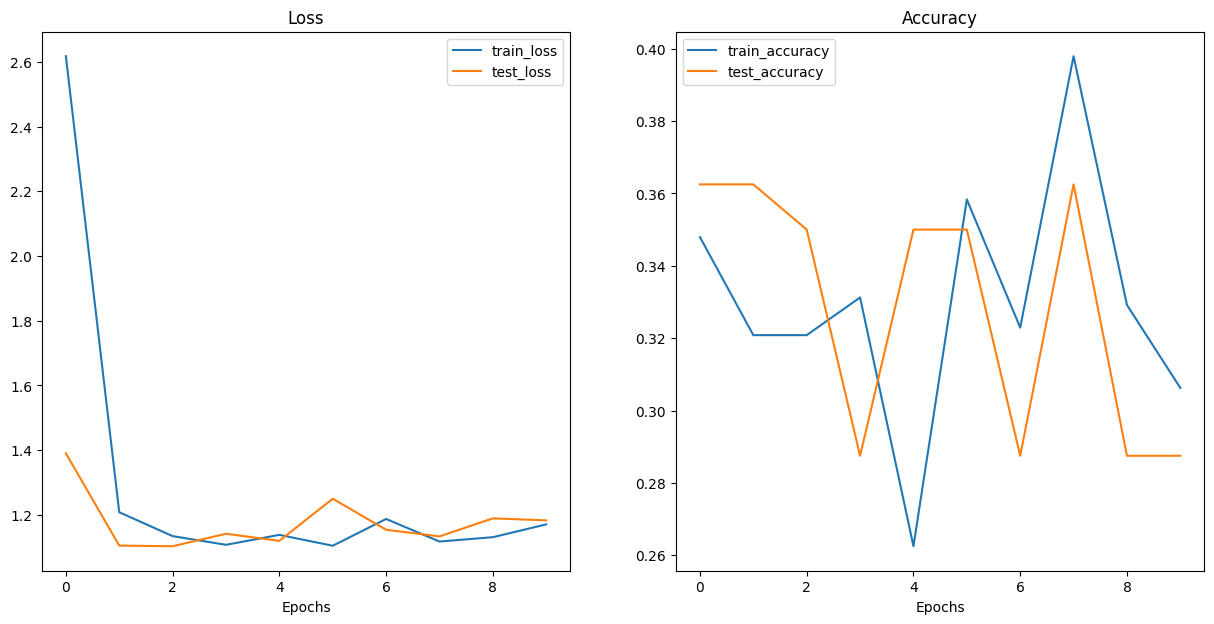

In [ ]:
# Plot our ViT model's loss curves
from going_modular.utils import plot_loss_curves
plot_loss_curves(results)

### Using a pretrained ViT from torchvision.models on the same dataset

In [ ]:
"""
Getting a pretrained ViT model and creating a feature extractor

1. Get the pretrained weights for ViT-Base trained on ImageNet-1k from torchvision.models.ViT_B_16_Weights.DEFAULT (DEFAULT stands for best available).
2. Setup a ViT model instance via torchvision.models.vit_b_16, pass it the pretrained weights from step 1 and send it to the target device.
3. Freeze all of the parameters in the base ViT model created in step 2 by setting their requires_grad attribute to False.
4. Update the classifier head of the ViT model created in step 2 to suit our own problem by changing the number of out_features to our number of classes (pizza, steak, sushi).
"""
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # "DEFAULT" is best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze all of the base parameters in the base ViT model
for parm in pretrained_vit.parameters():
  parm.requires_grad = False

# 4. Update the classifier head of the pretrained ViT model to suit our dataset
set_seeds()  # set the seeds to ensure same initialization with linear head
pretrained_vit.heads = torch.nn.Linear(in_features=768,
                                       out_features=len(class_names)).to(device)

pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 114MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Print a summary of our pretrained ViT model using torchinfo
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20,
    transform=pretrained_vit_transforms,
    batch_size=32  # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
)

In [ ]:
"""
Train feature extractor ViT model on our dataset
"""
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_results = engine.train(model=pretrained_vit,
                                  train_dataloader=train_dataloader_pretrained,
                                  test_dataloader=test_dataloader_pretrained,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=10,
                                  device=device)

print(f"Max test acc: {max(pretrained_results['test_acc']):.3f} | Min test loss: {min(pretrained_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
Max test acc: 0.985 | Min test loss: 0.064


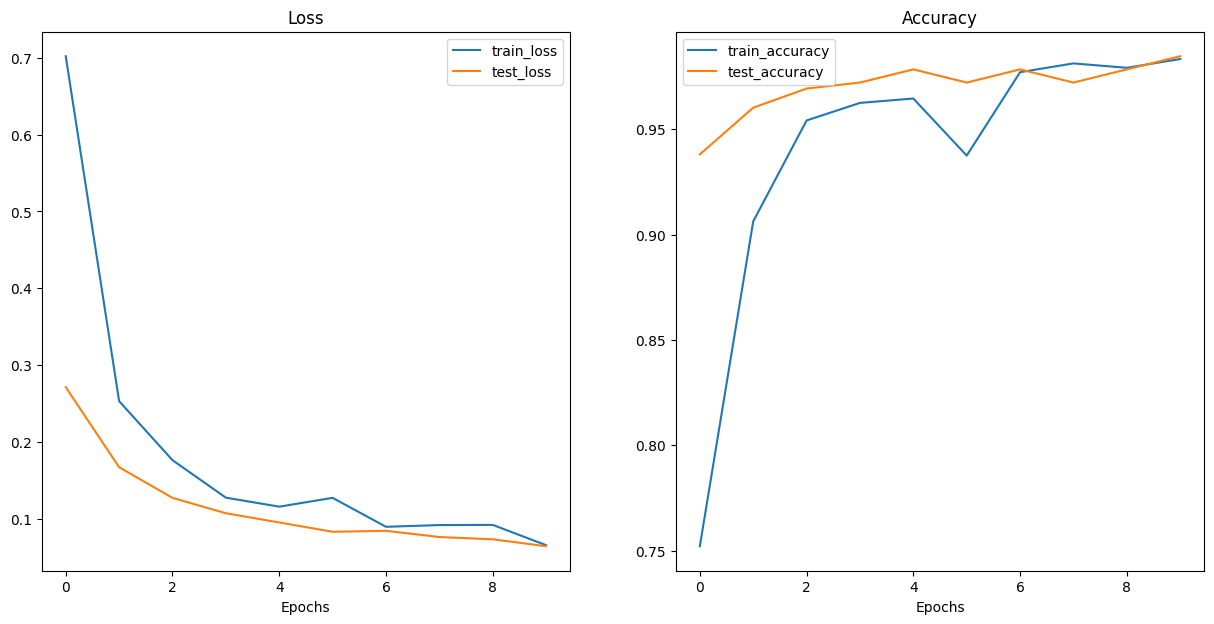

In [ ]:
# Plot loss and accuracy
from going_modular.utils import plot_loss_curves
plot_loss_curves(pretrained_results)

In [ ]:
# Save the model
from going_modular.utils import save_model
save_model(model=pretrained_vit,
           target_dir="models",
           model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [ ]:
# Get model size
model_path = "models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth"
model_size = Path(model_path).stat().st_size // (1024 * 1024)  # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [ ]:
"""
Predict on my own images
"""
# Get custom images
!python going_modular/get_custom_data.py

DownLoading data/cheese-pizza.jpeg...
DownLoading data/pizza-slice.jpeg...
DownLoading data/pizza-slice2.jpeg...
DownLoading data/pizza-sliced.jpeg...
DownLoading data/pizza-sliced2.jpeg...
DownLoading data/pizza-partial-view.jpeg...
DownLoading data/pizza-partial-view2.jpeg...
DownLoading data/pizza-side-view.jpeg...


In [ ]:
from going_modular.utils import pred_and_plot_image
from pathlib import Path

class_names = ["pizza", "steak", "sushi"]
data_path = Path("data")

filenames = [
    "cheese-pizza.jpeg",
    "pizza-slice.jpeg",
    "pizza-slice2.jpeg",
    "pizza-sliced.jpeg",
    "pizza-sliced2.jpeg",
    "pizza-partial-view.jpeg",
    "pizza-partial-view2.jpeg",
    "pizza-side-view.jpeg"
]

for f in filenames:
  # Set custom image path
  custom_image_path = data_path / f
  # Predict on custom image
  pred_and_plot_image(model=pretrained_vit,
                      image_path=custom_image_path,
                      class_names=class_names,
                      transform=pretrained_vit_transforms,
                      device=device)

Output hidden; open in https://colab.research.google.com to view.

## 1. Replicate the ViT architecture we created with in-built PyTorch transformer layers.

In [ ]:
"""
Replace our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
Then stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder(). (See step 9b.)
"""
# 1. Create a ViT class that inherits from nn.Module
class ViT_1(nn.Module):
  """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
  """
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               img_size:int=224,               # Training resolution from Table 3 in ViT paper
               in_channels:int=3,              # Number of channels in input image
               patch_size:int=16,              # Patch size
               num_transformer_layers:int=12,  # Layers from Table 1 for ViT-Base
               embedding_dim:int=768,          # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,              # MLP size from Table 1 for ViT-Base
               num_heads:int=12,               # Heads from Table 1 for ViT-Base
               #attn_dropout:float=0,           # Dropout for attention projection
               mlp_dropout:float=0.1,          # Dropout for dense/MLP layers
               embedding_dropout:float=0.1,    # Dropout for patch and position embeddings
               num_classes:int=1000):          # Default for ImageNet but can customize this

    super().__init__()

    # 3. Make sure the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    # 4. Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # 5. Create learnable class embedding (or class_token) (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                          requires_grad=True)

    # 7. Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    """
    # 9. Create Transformer Encoder layer (single)
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dim_feedforward=mlp_size,
        dropout=mlp_dropout,
        activation="gelu",
        batch_first=True,
        norm_first=True
    )
    """
    # 9b. Create stacked Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(
        encoder_layer=nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=mlp_size,
            #dropout=mlp_dropout,
            activation="gelu",
            batch_first=True#,  # Create a single Transformer Encoder layer
            #norm_first=True
        ),
        num_layers=num_transformer_layers  # Stack it N times
    )

    # 10. Create classifier head (or MLP_head)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimension (try this line on its own)

    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # 17. Run embedding dropout (Appendix B.1)
    x = self.embedding_dropout(x)

    # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

    return x

## 2. Turn the custom ViT architecture we created into a Python script, for example, vit.py.

In [ ]:
%%writefile vit.py
import torch
from torch import nn

"""
Copy in all dependencies for the ViT model vit.py file
"""
# 1. Create a class which subclasses nn.Module
class PatchEmbedding_2(nn.Module):
  """Turns a 2D input image into a 1D sequence learnable embedding vector.

  Args:
      in_channels (int): Number of color channels for the input images. Defaults to 3.
      patch_size (int): Size of patches to convert input image into. Defaults to 16.
      embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
  """
  # 2. Initialize the class with appropriate variables
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768):
    super().__init__()  # instantiate the parent class

    self.patch_size = patch_size  # Store patch_size as a class attribute

    # 3. Create a layer to turn an image into patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    # 4. Create a layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2,  # only flatten the feature map dimensions into a single vector
                              end_dim=3)

  # 5. Define the forward method
  def forward(self, x):
    # Create assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    #assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"
    assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

    # Perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)
    # 6. Make sure the output shape has the right order
    return x_flattened.permute(0, 2, 1)  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


"""
Replace our TransformerEncoderBlock() class with torch.nn.TransformerEncoderLayer() (these contain the same layers as our custom blocks).
Then stack torch.nn.TransformerEncoderLayer()'s on top of each other with torch.nn.TransformerEncoder(). (See step 9b.)
"""
# 1. Create a ViT class that inherits from nn.Module
class ViT_2(nn.Module):
  """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default.
  """
  # 2. Initialize the class with hyperparameters from Table 1 and Table 3
  def __init__(self,
               img_size:int=224,               # Training resolution from Table 3 in ViT paper
               in_channels:int=3,              # Number of channels in input image
               patch_size:int=16,              # Patch size
               num_transformer_layers:int=12,  # Layers from Table 1 for ViT-Base
               embedding_dim:int=768,          # Hidden size D from Table 1 for ViT-Base
               mlp_size:int=3072,              # MLP size from Table 1 for ViT-Base
               num_heads:int=12,               # Heads from Table 1 for ViT-Base
               #attn_dropout:float=0,           # Dropout for attention projection
               mlp_dropout:float=0.1,          # Dropout for dense/MLP layers
               embedding_dropout:float=0.1,    # Dropout for patch and position embeddings
               num_classes:int=1000):          # Default for ImageNet but can customize this

    super().__init__()

    # 3. Make sure the image size is divisible by the patch size
    assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}"

    # 4. Calculate number of patches (height * width/patch^2)
    self.num_patches = (img_size * img_size) // patch_size**2

    # 5. Create learnable class embedding (or class_token) (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)

    # 6. Create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                          requires_grad=True)

    # 7. Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # 8. Create patch embedding layer
    self.patch_embedding = PatchEmbedding_2(in_channels=in_channels,
                                            patch_size=patch_size,
                                            embedding_dim=embedding_dim)
    """
    # 9. Create Transformer Encoder layer (single)
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dim_feedforward=mlp_size,
        dropout=mlp_dropout,
        activation="gelu",
        batch_first=True,
        norm_first=True
    )
    """
    # 9b. Create stacked Transformer Encoder layers (stacked single layers)
    self.transformer_encoder = nn.TransformerEncoder(
        encoder_layer=nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dim_feedforward=mlp_size,
            #dropout=mlp_dropout,
            activation="gelu",
            batch_first=True#,  # Create a single Transformer Encoder layer
            #norm_first=True
        ),
        num_layers=num_transformer_layers  # Stack it N times
    )

    # 10. Create classifier head (or MLP_head)
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

  # 11. Create a forward() method
  def forward(self, x):

    # 12. Get batch size
    batch_size = x.shape[0]

    # 13. Create class token embedding and expand it to match the batch size (equation 1)
    class_token = self.class_embedding.expand(batch_size, -1, -1)  # "-1" means to infer the dimension (try this line on its own)

    # 14. Create patch embedding (equation 1)
    x = self.patch_embedding(x)

    # 15. Concat class embedding and patch embedding (equation 1)
    x = torch.cat((class_token, x), dim=1)

    # 16. Add position embedding to patch embedding (equation 1)
    x = self.position_embedding + x

    # 17. Run embedding dropout (Appendix B.1)
    x = self.embedding_dropout(x)

    # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
    x = self.transformer_encoder(x)

    # 19. Put 0 index logit through classifier (equation 4)
    x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

    return x

Writing vit.py


In [ ]:
from vit import ViT_2

imported_vit = ViT_2()  # instantiate a model
summary(model=imported_vit,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT_2 (ViT_2)                                           [32, 3, 224, 224]    [32, 1000]           152,064              True
├─PatchEmbedding_2 (patch_embedding)                    [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

In [ ]:
"""
Train the imported ViT_2 model on our dataset
"""
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=imported_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
imported_vit_results = engine.train(model=imported_vit,
                                    train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=10,
                                    device=device)

print(f"Max test acc: {max(imported_vit_results['test_acc']):.3f} | Min test loss: {min(imported_vit_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.1826 | train_acc: 0.2812 | test_loss: 1.1941 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.2300 | train_acc: 0.3083 | test_loss: 1.1584 | test_acc: 0.3500
Epoch: 3 | train_loss: 1.2402 | train_acc: 0.3042 | test_loss: 1.1857 | test_acc: 0.3625
Epoch: 4 | train_loss: 1.1375 | train_acc: 0.3521 | test_loss: 1.1200 | test_acc: 0.3625
Epoch: 5 | train_loss: 1.1340 | train_acc: 0.3542 | test_loss: 1.1157 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.1221 | train_acc: 0.3563 | test_loss: 1.3253 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.2064 | train_acc: 0.3146 | test_loss: 1.1550 | test_acc: 0.2875
Epoch: 8 | train_loss: 1.1212 | train_acc: 0.3646 | test_loss: 1.1268 | test_acc: 0.3625
Epoch: 9 | train_loss: 1.1668 | train_acc: 0.3417 | test_loss: 1.2109 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.2054 | train_acc: 0.2812 | test_loss: 1.3341 | test_acc: 0.2875
Max test acc: 0.362 | Min test loss: 1.116


In [ ]:
# Get custom images
!python going_modular/get_custom_data.py

DownLoading data/cheese-pizza.jpeg...
DownLoading data/pizza-slice.jpeg...
DownLoading data/pizza-slice2.jpeg...
DownLoading data/pizza-sliced.jpeg...
DownLoading data/pizza-sliced2.jpeg...
DownLoading data/pizza-partial-view.jpeg...
DownLoading data/pizza-partial-view2.jpeg...
DownLoading data/pizza-side-view.jpeg...


In [ ]:
from going_modular.utils import pred_and_plot_image
from pathlib import Path

class_names = ["pizza", "steak", "sushi"]
data_path = Path("data")

filenames = [
    "cheese-pizza.jpeg",
    "pizza-slice.jpeg",
    "pizza-slice2.jpeg",
    "pizza-sliced.jpeg",
    "pizza-sliced2.jpeg",
    "pizza-partial-view.jpeg",
    "pizza-partial-view2.jpeg",
    "pizza-side-view.jpeg"
]

for f in filenames:
  # Set custom image path
  custom_image_path = data_path / f
  # Predict on custom image
  pred_and_plot_image(model=imported_vit,
                      image_path=custom_image_path,
                      class_names=class_names,
                      transform=manual_transforms,
                      device=device,
                      image_size=(224, 224))  # keyword arguments can be in any order

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
Create a random tensor in the same shape as a single image, pass to an instance of ViT_2 and see what happens.
"""
# Set seeds
set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT_2 with the number of classes we're working with (pizza, steak, sushi)
imported_vit_2 = ViT_2(num_classes=len(class_names))

# Pass the random image tensor to our ViT_2 instance
imported_vit_2(random_image_tensor)

tensor([[ 0.7728, -0.9260,  0.3235]], grad_fn=<AddmmBackward0>)

In [ ]:
# Print a summary of our custom ViT model using torchinfo
summary(model=imported_vit_2,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT_2 (ViT_2)                                           [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding_2 (patch_embedding)                    [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                 [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─TransformerEncoder (transformer_encoder)              [32, 197, 768]       [32, 197, 768]       --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

In [ ]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=imported_vit_2.parameters(),
                             lr=3e-3,             # 0.003 Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3)    # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
imported_vit2_results = engine.train(model=imported_vit_2.to(device),
                                     train_dataloader=train_dataloader,
                                     test_dataloader=test_dataloader,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

print(f"Max test acc: {max(imported_vit2_results['test_acc']):.3f} | Min test loss: {min(imported_vit2_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.5017 | train_acc: 0.3521 | test_loss: 1.3210 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.3329 | train_acc: 0.3187 | test_loss: 1.3061 | test_acc: 0.3500
Epoch: 3 | train_loss: 1.1681 | train_acc: 0.3625 | test_loss: 1.1793 | test_acc: 0.3500
Epoch: 4 | train_loss: 1.1709 | train_acc: 0.3375 | test_loss: 1.1658 | test_acc: 0.2875
Epoch: 5 | train_loss: 1.1224 | train_acc: 0.2625 | test_loss: 1.1016 | test_acc: 0.3625
Epoch: 6 | train_loss: 1.1309 | train_acc: 0.3083 | test_loss: 1.1114 | test_acc: 0.3625
Epoch: 7 | train_loss: 1.1586 | train_acc: 0.2771 | test_loss: 1.1218 | test_acc: 0.3625
Epoch: 8 | train_loss: 1.1695 | train_acc: 0.3292 | test_loss: 1.1757 | test_acc: 0.2875
Epoch: 9 | train_loss: 1.2310 | train_acc: 0.3187 | test_loss: 1.1058 | test_acc: 0.3500
Epoch: 10 | train_loss: 1.2168 | train_acc: 0.3250 | test_loss: 1.2192 | test_acc: 0.3500
Max test acc: 0.362 | Min test loss: 1.102


In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # "DEFAULT" is best available
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

for f in filenames:
  # Set custom image path
  custom_image_path = data_path / f
  # Predict on custom image
  pred_and_plot_image(model=imported_vit_2,
                      image_size=(224, 224),  # keyword arguments can be in any order
                      image_path=custom_image_path,
                      class_names=class_names,
                      transform=pretrained_vit_transforms,  # or manual_transforms
                      device=device,
                      )

Output hidden; open in https://colab.research.google.com to view.

## 3. Train a pretrained ViT feature extractor model on the 20% pizza, steak, sushi dataset

In [ ]:
"""
Already done above with pretrained_vit, but this time include nn.LayerNorm() in the classifier head.
"""
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT  # "DEFAULT" is best available

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()

# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20,
    transform=pretrained_vit_transforms,
    batch_size=32  # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
)

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit_3 = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze all of the base parameters in the base ViT model
for parm in pretrained_vit_3.parameters():
  parm.requires_grad = False

# 4. Update the classifier head of the pretrained ViT model to suit our dataset
""" include nn.LayerNorm this time """
set_seeds()  # set the seeds to ensure same initialization with linear head
pretrained_vit_3.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),  # embedding_dim = 768
    nn.Linear(in_features=768,
              out_features=len(class_names))
).to(device)

pretrained_vit_3

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 188MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
# Print a summary of our pretrained ViT model using torchinfo
summary(model=pretrained_vit_3,
        input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
"""
Train feature extractor ViT model on our dataset
"""
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_3.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_3_results = engine.train(model=pretrained_vit_3,
                                  train_dataloader=train_dataloader_pretrained,
                                  test_dataloader=test_dataloader_pretrained,
                                  optimizer=optimizer,
                                  loss_fn=loss_fn,
                                  epochs=10,
                                  device=device)

print(f"Max test acc: {max(pretrained_3_results['test_acc']):.3f} | Min test loss: {min(pretrained_3_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6443 | train_acc: 0.7521 | test_loss: 0.1878 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2036 | train_acc: 0.9167 | test_loss: 0.1347 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1399 | train_acc: 0.9583 | test_loss: 0.1051 | test_acc: 0.9784
Epoch: 4 | train_loss: 0.1000 | train_acc: 0.9688 | test_loss: 0.0902 | test_acc: 0.9784
Epoch: 5 | train_loss: 0.0881 | train_acc: 0.9771 | test_loss: 0.0811 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.0924 | train_acc: 0.9521 | test_loss: 0.0706 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0655 | train_acc: 0.9812 | test_loss: 0.0736 | test_acc: 0.9722
Epoch: 8 | train_loss: 0.0575 | train_acc: 0.9875 | test_loss: 0.0705 | test_acc: 0.9784
Epoch: 9 | train_loss: 0.0657 | train_acc: 0.9938 | test_loss: 0.0652 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.0411 | train_acc: 0.9938 | test_loss: 0.0595 | test_acc: 0.9784
Max test acc: 0.978 | Min test loss: 0.059


## 4. Use the "ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1" pretrained weights

In [ ]:
"""
Repeat the pretrained ViT model training but this time with "ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1"
pretrained weights from torchvision.models.vit_b_16().
"""
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1  # different than "DEFAULT"

# 2. Set up a ViT model instance with pretrained weights
pretrained_vit_swag = torchvision.models.vit_b_16(weights=pretrained_vit_weights_swag).to(device)

# 3. Freeze all of the base parameters in the base ViT model
for parm in pretrained_vit_swag.parameters():
  parm.requires_grad = False

# 4. Update the classifier head of the pretrained ViT model to suit our dataset
set_seeds()  # set the seeds to ensure same initialization with linear head
"""pretrained_vit_swag.heads = torch.nn.Linear(in_features=768,
                                            out_features=len(class_names)).to(device)"""
pretrained_vit_swag.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),  # embedding_dim = 768
    nn.Linear(in_features=768,
              out_features=len(class_names))
).to(device)

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms_swag = pretrained_vit_weights_swag.transforms()
pretrained_vit_transforms_swag

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:06<00:00, 55.7MB/s]


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained_swag, test_dataloader_pretrained_swag, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20,
    transform=pretrained_vit_transforms_swag,
    batch_size=32  # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
)

"""
Train feature extractor ViT model on our dataset
"""
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_swag.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_swag_results = engine.train(model=pretrained_vit_swag,
                                       train_dataloader=train_dataloader_pretrained_swag,
                                       test_dataloader=test_dataloader_pretrained_swag,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       epochs=10,
                                       device=device)

print(f"Max test acc: {max(pretrained_swag_results['test_acc']):.3f} | Min test loss: {min(pretrained_swag_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4469 | train_acc: 0.9000 | test_loss: 0.0269 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0490 | train_acc: 0.9854 | test_loss: 0.0183 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0299 | train_acc: 0.9896 | test_loss: 0.0105 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0206 | train_acc: 0.9979 | test_loss: 0.0067 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0156 | train_acc: 1.0000 | test_loss: 0.0058 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0128 | train_acc: 1.0000 | test_loss: 0.0049 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0103 | train_acc: 1.0000 | test_loss: 0.0042 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0123 | train_acc: 1.0000 | test_loss: 0.0040 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0081 | train_acc: 1.0000 | test_loss: 0.0052 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0078 | train_acc: 1.0000 | test_loss: 0.0035 | test_acc: 1.0000
Max test acc: 1.000 | Min test loss: 0.003


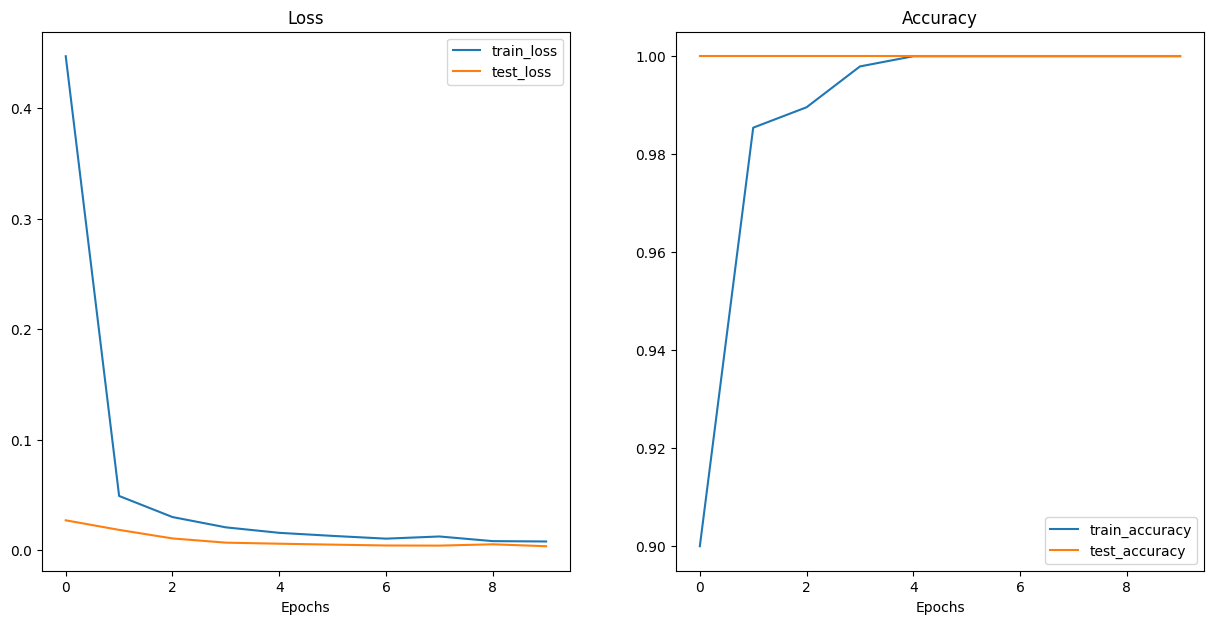

In [ ]:
# Plot loss and accuracy
from going_modular.utils import plot_loss_curves
plot_loss_curves(pretrained_swag_results)

In [ ]:
for f in filenames:
  # Set custom image path
  custom_image_path = data_path / f
  # Predict on custom image
  pred_and_plot_image(model=pretrained_vit_swag,
                      image_path=custom_image_path,
                      class_names=class_names,
                      transform=pretrained_vit_transforms_swag,
                      device=device)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
"""
Repeat the pretrained_vit_swag model training, but this time with nn.LayerNorm() in the classifier head.
"""
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights_swag = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1  # different than "DEFAULT"

# 2. Set up a ViT model instance with pretrained weights
pretrained_vit_swag_4 = torchvision.models.vit_b_16(weights=pretrained_vit_weights_swag).to(device)

# 3. Freeze all of the base parameters in the base ViT model
for parm in pretrained_vit_swag_4.parameters():
  parm.requires_grad = False

# 4. Update the classifier head of the pretrained ViT model to suit our dataset
set_seeds()  # set the seeds to ensure same initialization with linear head
"""pretrained_vit_swag.heads = torch.nn.Linear(in_features=768,
                                            out_features=len(class_names)).to(device)"""
pretrained_vit_swag_4.heads = nn.Sequential(
    nn.LayerNorm(normalized_shape=768),  # embedding_dim = 768
    nn.Linear(in_features=768,
              out_features=len(class_names))
).to(device)

# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms_swag = pretrained_vit_weights_swag.transforms()
pretrained_vit_transforms_swag

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:03<00:00, 97.6MB/s]


ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained_swag, test_dataloader_pretrained_swag, class_names = data_setup.create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir_20,
    transform=pretrained_vit_transforms_swag,
    batch_size=32  # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)
)

"""
Train feature extractor ViT model on our dataset
"""
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit_swag_4.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_swag_4_results = engine.train(model=pretrained_vit_swag_4,
                                         train_dataloader=train_dataloader_pretrained_swag,
                                         test_dataloader=test_dataloader_pretrained_swag,
                                         optimizer=optimizer,
                                         loss_fn=loss_fn,
                                         epochs=10,
                                         device=device)

print(f"Max test acc: {max(pretrained_swag_4_results['test_acc']):.3f} | Min test loss: {min(pretrained_swag_4_results['test_loss']):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4661 | train_acc: 0.9000 | test_loss: 0.0513 | test_acc: 1.0000
Epoch: 2 | train_loss: 0.0641 | train_acc: 0.9854 | test_loss: 0.0281 | test_acc: 1.0000
Epoch: 3 | train_loss: 0.0407 | train_acc: 0.9875 | test_loss: 0.0165 | test_acc: 1.0000
Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9938 | test_loss: 0.0115 | test_acc: 1.0000
Epoch: 5 | train_loss: 0.0241 | train_acc: 0.9938 | test_loss: 0.0098 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0205 | train_acc: 0.9979 | test_loss: 0.0083 | test_acc: 1.0000
Epoch: 7 | train_loss: 0.0168 | train_acc: 0.9979 | test_loss: 0.0070 | test_acc: 1.0000
Epoch: 8 | train_loss: 0.0197 | train_acc: 0.9979 | test_loss: 0.0065 | test_acc: 1.0000
Epoch: 9 | train_loss: 0.0131 | train_acc: 1.0000 | test_loss: 0.0077 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0123 | train_acc: 0.9979 | test_loss: 0.0056 | test_acc: 1.0000
Max test acc: 1.000 | Min test loss: 0.006
